In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import gpflow as gp
from bayes_tec.datapack import DataPack
from bayes_tec.utils.data_utils import make_coord_array, calculate_weights
from timeit import default_timer
import pylab as plt
plt.style.use('ggplot')
import astropy.coordinates as ac
import astropy.time as at
import astropy.units as au

jitter = 1e-6

def make_solsets(datapack,output_solset, screen_res=15, extend = 0.25, solset='sol000'):
    screen_solset = "screen_{}".format(output_solset)
    
    datapack.switch_solset(solset)
    datapack.select(ant=None,time=None, dir=None, freq=None, pol=slice(0,1,1))
    axes = datapack.__getattr__("axes_{}".format('phase'))

    antenna_labels, antennas = datapack.get_antennas(axes['ant'])
    patch_names, directions = datapack.get_sources(axes['dir'])
    timestamps, times = datapack.get_times(axes['time'])
    freq_labels, freqs = datapack.get_freqs(axes['freq'])
    pol_labels, pols = datapack.get_pols(axes['pol'])

    Npol, Nd, Na, Nf, Nt = len(pols), len(directions), len(antennas), len(freqs), len(times)
    
#     screen_directions = dialated_faceted(directions.ra.rad.mean(), directions.dec.rad.mean(),
#                                         N=screen_res)

    screen_ra = np.linspace(np.min(directions.ra.rad) - extend*np.pi/180., 
            np.max(directions.ra.rad) + extend*np.pi/180., screen_res)
    screen_dec = np.linspace(max(-90.*np.pi/180.,np.min(directions.dec.rad) - extend*np.pi/180.), 
            min(90.*np.pi/180.,np.max(directions.dec.rad) + extend*np.pi/180.), screen_res)
    screen_directions = np.stack([m.flatten() \
            for m in np.meshgrid(screen_ra, screen_dec, indexing='ij')], axis=1)
    screen_directions = ac.SkyCoord(screen_directions[:,0]*au.rad,screen_directions[:,1]*au.rad,frame='icrs')
    Nd_screen = screen_res**2

    datapack.switch_solset(output_solset, 
            array_file=DataPack.lofar_array, 
            directions = np.stack([directions.ra.rad,directions.dec.rad],axis=1), patch_names=patch_names)
    datapack.add_freq_indep_tab('tec', times.mjd*86400., pols = pol_labels)   
    datapack.add_freq_dep_tab('amplitude', times.mjd*86400., pols = pol_labels,freqs=freqs)
    datapack.add_freq_dep_tab('phase', times.mjd*86400., pols = pol_labels,freqs=freqs)


    datapack.switch_solset(screen_solset, 
            array_file = DataPack.lofar_array, 
            directions = np.stack([screen_directions.ra.rad,screen_directions.dec.rad],axis=1))
    datapack.add_freq_indep_tab('tec', times.mjd*86400., pols = pol_labels)
    datapack.add_freq_dep_tab('amplitude', times.mjd*86400., pols = pol_labels,freqs=freqs)
    datapack.add_freq_dep_tab('phase', times.mjd*86400., pols = pol_labels,freqs=freqs)

    datapack.switch_solset(solset)
    
def get_solset_coords(datapack,solset):
    datapack.switch_solset(solset)
    axes = datapack.axes_phase
    antenna_labels, antennas = datapack.get_antennas(axes['ant'])
    patch_names, directions = datapack.get_sources(axes['dir'])
    timestamps, times = datapack.get_times(axes['time'])
    freq_labels, freqs = datapack.get_freqs(axes['freq'])
    pol_labels, pols = datapack.get_pols(axes['pol'])
    
    antennas_enu = antennas.transform_to(ENU(obstime=times[0],location=datapack.array_center))
    X_a = np.array([antennas_enu.east.value,
                    antennas_enu.north.value]).T/1000.
    X_d = np.array([directions.ra.deg - directions.ra.deg.mean(), directions.dec.deg - directions.dec.deg.mean()]).T
    X_t = (times.mjd*86400 - times[0].mjd*86400.)[:,None]
    X_f = freqs[:,None]/100e6 - freqs[0]/100e6
    
    return X_t, X_d, X_a, X_f
    


from collections import namedtuple

DataStream = namedtuple('DataStream',['Xt', 'Xd', 'Xa','Yt', 'St'])
ScreenStream = namedtuple('ScreenStream',['Xd', 'Xa'])
BasisStream = namedtuple('BasisStream',['Xd', 'Xa'])


def iteration_moving_activate_set_while_loop(data_coords, screen_coords, basis_coords, 
                                             kern, mean, Nb=40, dt=15., lag=3,
                                            X0 = None, C0 = None, mu0=None, resume=None):
    """Perform one iteration of RGP.
    Args:
    :param data_coords: DataStream contains Tensors for constructing the data.
    :param screen_coords: ScreenStream contains Tensors for constructing the coordinates of screen.
    :param basis_coords: BasisStream contains Tensors for constructing the coordinates of basis.
    :param kern: gp.kernels.Kernel the covariance of GP
        Signature: (N, ndim) -> (D, N, N)
    :param mean: callable the mean of GP, 
        Signature: (N, ndim) -> (D, N)
    :param Nb: int Tensor num of points along time for basis
    :param dt: float Tensor spacing of basis points in time
    :param lag: int Tensor lag behind in indices to wait before posterior prediction at screen
    :param X0: Tensor (S, ndim) init coords or None
    :param C0: Tensor (S,S) init covariance or None
    :param mu0: Tensor (D,S) init mean or None
    :param resume: Tensor bool, whether to use given inits
    
        
    Returns:
    tensor arrays
    """
    
    # len of data stream and also the screen stream
    Nt = tf.shape(data_coords.Xt)[0]
    T = dt * Nb/2.
    lag = tf.convert_to_tensor(lag,dtype=tf.int32)
    D = tf.shape(data_coords.Yt)[0]
    
    def _make_coord_array(*X):
        return tf.py_func(make_coord_array,X,tf.float64,stateful=False)
    
    def _data_stream(i):
        i = tf.maximum(tf.minimum(i, Nt-1), 0)
        X = _make_coord_array(data_coords.Xt[i:i+1,:], data_coords.Xd, data_coords.Xa)
        Y = tf.reshape(data_coords.Yt[:,i,...], tf.concat([[D], tf.constant([-1])],axis=0))
        S = tf.reshape(data_coords.St[:,i,...], tf.concat([[D], tf.constant([-1])],axis=0))
        return i, X,Y,S
    
    def _do_update(i):
        return tf.less(i,Nt)
    
    
    def _predict_screen(i):
        i = tf.minimum(tf.maximum(i - lag, 0), Nt-1)
        return tf.less(i,Nt)
    
    def _screen_stream_not_done_dataset(i):
#         i = tf.minimum(tf.maximum(i - lag, 0), Nt-1)
        return tf.less(i,Nt+lag)
    
    def _screen_stream(i):
        do_predict = tf.greater_equal(i,lag)
        i = tf.minimum(tf.maximum(i-lag, 0), Nt-1)
        X = _make_coord_array(data_coords.Xt[i:i+1,:], screen_coords.Xd, screen_coords.Xa)
        return i, X, do_predict
    
    def _basis_stream(i):
        i = tf.minimum(tf.maximum(i+1, 0), Nt-1)
        X = _make_coord_array(data_coords.Xt[i:i+1,:] + T, basis_coords.Xd, basis_coords.Xa)
        return X
    
    ###
    # Make dataset streams
    dataset = tf.data.Dataset.from_tensor_slices(tf.range(Nt+lag+1,dtype=tf.int32))
    index_dataset = dataset.make_initializable_iterator()
    do_update_dataset = dataset.map(_do_update ,num_parallel_calls=10).make_initializable_iterator()
    screen_stream_not_done_dataset = dataset.map(_screen_stream_not_done_dataset, num_parallel_calls=10).make_initializable_iterator()
    data_dataset = dataset.map(_data_stream ,num_parallel_calls=10).make_initializable_iterator()
    screen_dataset = dataset.map(_screen_stream ,num_parallel_calls=10).make_initializable_iterator()
    basis_dataset = dataset.map(_basis_stream ,num_parallel_calls=10).make_initializable_iterator()
    
    inits = tf.group([index_dataset.initializer,
            do_update_dataset.initializer,
            data_dataset.initializer,
            screen_stream_not_done_dataset.initializer,
            screen_dataset.initializer,
            basis_dataset.initializer])

    
    
    
    

    
    
    data_X_ta = tf.TensorArray(tf.float64,size=Nt)
    data_mu_ta = tf.TensorArray(tf.float64,size=Nt)
    data_C_ta = tf.TensorArray(tf.float64,size=Nt)
    
    screen_X_ta = tf.TensorArray(tf.float64,size=Nt)
    screen_mu_ta = tf.TensorArray(tf.float64,size=Nt)
    screen_C_ta = tf.TensorArray(tf.float64,size=Nt)
    
    basis_X_ta = tf.TensorArray(tf.float64,size=Nt)
    basis_mu_ta = tf.TensorArray(tf.float64,size=Nt)
    basis_C_ta = tf.TensorArray(tf.float64,size=Nt)
    
    log_prob_ta = tf.TensorArray(tf.float64,size=Nt)
    
    def _cond(*args):
        return screen_stream_not_done_dataset.get_next()
    
    def _body(Xb_last, mugt1, Cgt1, L_last, 
              data_X_ta, data_mu_ta, data_C_ta, 
              screen_X_ta, screen_mu_ta, screen_C_ta, 
             basis_X_ta, basis_mu_ta, basis_C_ta, log_prob_ta):
        """
        Do an iteration of:
        1. basis translation Xb[i0:i1,...] -> Xb[i0+1:i1+1,...]
            a. build from components (New slice is at t[i] + T)
        3. translation of screen prediction Xstar[j,...] -> Xstar[j+1,...]
            a. build from components (New predict is at max(i, i - lag))
        3. translation of data feed Xt[i,...] -> Xt[i+1,...], similarly for Y and Y_var
        4. predict
        5. update
        6. store
        If no new data, then don't to the update step. I.e. Cq[t] = Cq[t-1]
        """
        
        i = index_dataset.get_next()
        i_data, X_data, Yt, St = data_dataset.get_next()
        
        i_screen, X_screen, predict_screen = screen_dataset.get_next()
        X_basis_new = basis_dataset.get_next()
        
        do_update = do_update_dataset.get_next()
        
        dt_tol = tf.constant(0.1,dtype=X_data.dtype)
        
        #width of last basis is T
        same_rel_basis = tf.less(
                tf.abs(tf.reduce_max(X_basis_new[:,0]) - tf.reduce_min(Xb_last[:,0]) - dt*(Nb+1)), 
                dt_tol)
        
#         same_rel_basis = tf.constant(True)
        
        
        i_data = tf.Print(i_data,[i,i_data,same_rel_basis,
                                  tf.reduce_max(X_basis_new[:,0]),
                                  tf.reduce_min(Xb_last[:,0]),
                                 tf.reduce_max(X_basis_new[:,0]) - tf.reduce_min(Xb_last[:,0]),
                                 dt*(Nb+1)],message='iteration: ')
        
        
        #Ne=Snew+Sstar, ndim
        Xe = tf.concat([X_basis_new, X_screen],axis=0)
        #Ne+N, ndim
        Xte = tf.concat([Xe,X_data],axis=0)
        
        Sstar = tf.shape(X_screen)[0]
        Ne = tf.shape(Xe)[0]
        Snew = tf.shape(X_basis_new)[0]
        N = tf.shape(X_data)[0]
        S = tf.shape(Xb_last)[0]

        

        basis_jitter = jitter*tf.eye(S, dtype=tf.float64)

        ###
        # Inference of basis vectors x_t|t-1

        ###
        # _Jt  = L^-1 Ktx
        # Jt   = Ktx Kxx^-1
        #      = Ktx (L L^T)^-1
        #      = _Jt^T L^-1
        # mupt = m(Xt) + Jt (mugt1 - m(X))
        #      = m(Xt) + _Jt^T L^-1 (mugt1 - m(X))
        # B    = Ktt - Ktx Kxx^-1 Kxt
        #      = Ktt - Ktx (L L^T)^-1 Kxt
        #      = Ktt - _Jt^T _Jt
        # Cpt  = B + Jt Cg_t1 Jt^T
        #      = B + Jt (Lg Lg^T) Jt^T
        #      = B + _Jt^T (L^-1 Lg) (Lg^T L^-T) _Jt
        #      = B + _Cpt^T _Cpt

        #D, Ne+N, Ne+N
        Ktt = kern.K(Xte,full_output_cov=False)
        #D, S, Ne+N
        Kxt = kern.K(Xb_last, Xte,full_output_cov=False)
        #D, S, S
        Kxx = kern.K(Xb_last,full_output_cov=False)
        
        #D, S, S
        L = tf.cond(same_rel_basis, 
                    lambda: L_last, 
                    lambda: tf.cholesky(Kxx + basis_jitter)) 

        #D, S, Ne+N
        _Jt = tf.linalg.triangular_solve(L, Kxt)

        #D, S, 1
        dmu = (mugt1 - mean(Xb_last))[:,:,None]
        #D, Ne+N, 1
        mupt = tf.matmul(_Jt, 
                         tf.linalg.triangular_solve(L, dmu), 
                         transpose_a=True) + mean(Xte)[:,:,None]

        #D, Ne+N, Ne+N
        B = Ktt - tf.matmul(_Jt, _Jt, transpose_a=True)
        #D, S, S
        Lg = tf.cholesky(Cgt1 + basis_jitter)

        #D, S, Ne+N
        _Cpt = tf.matmul(tf.linalg.triangular_solve(L, Lg),
                         _Jt, 
                         transpose_a = True)
        #D, Ne+N, Ne+N
        Cpt = B + tf.matmul(_Cpt,_Cpt,transpose_a=True)

        ###
        # Transfer extended basis
        # Cgt1    | Ggt1 Jt^T
        # -------------------
        # Jt Cgt1 | Cpt
        #
        #   a     |    b^T
        # -------------------
        #   b     |    c
        #
        # b = Jt Cgt1
        #   = _Jt^T L^-1 Cgt1
        #   = _Jt^T L^-1 (Lg Lg^T)
        #
        # qt1  = first D, S+Ne, S+Ne block
        # qpt = last D, N, N block
        # h = bottom left corner of whats left

        #D, S, S
        a = Cgt1

        #D, Ne+N, S
        b = tf.matmul(_Jt,
                     tf.linalg.triangular_solve(L, Cgt1),
                     transpose_a=True)
        #D, Ne+N, Ne+N
        c = Cpt

        #D, S+Ne,1
        muqt1 = tf.concat([mugt1[:,:,None],mupt[:,:Ne,:]],axis=1)
        #D, N,1
        muqpt = mupt[:,Ne:,:]

        #D, S+Ne, S+Ne
        Cqt1 = tf.concat([tf.concat([a,b[:,:Ne,:]],axis=1),
             tf.concat([tf.transpose(b[:,:Ne,:],(0,2,1)), c[:,:Ne,:Ne]],axis=1)],
                      axis=2)

        #D, N, N
        Cqpt = c[:,Ne:, Ne:]
        #D, N, S+Ne
        h = tf.concat([b[:,Ne:,:], c[:,Ne:,:Ne]],axis=2)
    
    
        ###
        # Update x_t|t
        # muqt = muqt1 + h^T (Cqpt + St)^-1 (Yt - mupt)
        #      = muqt1 + h^T (Ls Ls^T)^-1 (Yt - mupt)
        #      = mugt1 + _Cqt^T  _dY
        # Cqt  = Cqt1 - h^T (Cqpt + St)^-1 h
        #      = Cqt1 - h^T (Ls Ls^T)^-1 h
        #      = Cqt1 - _Cqt^T _Cqt
        # update at data
        # muet = muqpt + Cqpt (Cqpt + St)^-1 (Yt - mupt)
        #      = muqpt + Cqpt (Ls Ls^t)^-1 (Yt - mupt)
        #      = muqpt + _Cet^T _dY
        # Cet  = Cqpt - Cqpt (Cqpt + St)^-1 Cqpt
        #      = Cqpt - Cqpt (Ls Ls^T)^-1 Cqpt
        #      = Cqpt - _Cet^T _Cet
        # Cget = Cet h^T Cqpt^-1


        #D, N, N
        Ls = tf.cholesky(Cqpt + tf.matrix_diag(St))
        #D, N, S+Ne
        _Cqt = tf.linalg.triangular_solve(Ls, h)

        #D, N,1
        _dY = tf.linalg.triangular_solve(Ls, Yt[:,:,None] - muqpt)

        #D, S+Ne, 1
        muqt = muqt1 + tf.matmul(_Cqt, _dY, transpose_a=True)
        #D, S+Ne, S+Ne
        Cqt = Cqt1 - tf.matmul(_Cqt, _Cqt, transpose_a=True)

        #D, N, N
        _Cet = tf.linalg.triangular_solve(Ls, Cqpt)
        #D, N, 1
        muet = muqpt + tf.matmul(_Cet, _dY,transpose_a=True)
        #D, N, N
        Cet = Cqpt + tf.matmul(_Cet, _Cet, transpose_a=True)
        
        data_P = tfp.distributions.MultivariateNormalTriL(loc=muet[:,:,0],
                                                          scale_tril=tf.cholesky(Cet + jitter*tf.eye(N,dtype=tf.float64)))
        log_prob_data = tf.reduce_sum(data_P.log_prob(Yt))

        ###
        # split basis propagated solutions and predict
        # Ne = Snew + Sstar

        
        #S, ndim
        Xnext = tf.concat([Xb_last[Snew:,:],X_basis_new],axis=0)
#         #D, Sstar
#         muqt = muqt[:, Snew:S+Snew, 0]
#         #D, Sstar, Sstar
#         Cqt = Cqt[:, Snew:S+Snew, Snew:S+Snew]
        basis_res = (Xnext, muqt[:, Snew:S+Snew, 0], Cqt[:, Snew:S+Snew, Snew:S+Snew])
        screen_res = (X_screen, muqt[:, S+Snew:, 0], tf.matrix_diag_part(Cqt[:, S+Snew:, S+Snew:]))
        
#         #N, ndims
#         #D, N
#         #D, N, N
        data_res = (X_data, muet, tf.matrix_diag_part(Cet))
                                 
        (data_X_ta, 
         data_mu_ta, 
         data_C_ta, 
         screen_X_ta, 
         screen_mu_ta, 
         screen_C_ta,
         basis_X_ta, 
         basis_mu_ta, 
         basis_C_ta,
         log_prob_ta) = (tf.cond(do_update, lambda: data_X_ta.write(i_data, data_res[0]), lambda:data_X_ta), 
                         tf.cond(do_update, lambda: data_mu_ta.write(i_data, data_res[1]), lambda:data_mu_ta), 
                         tf.cond(do_update, lambda: data_C_ta.write(i_data, data_res[2]), lambda:data_C_ta),
                         tf.cond(predict_screen, lambda:screen_X_ta.write(i_screen, screen_res[0]),lambda:screen_X_ta), 
                         tf.cond(predict_screen, lambda:screen_mu_ta.write(i_screen, screen_res[1]),lambda:screen_mu_ta), 
                         tf.cond(predict_screen, lambda:screen_C_ta.write(i_screen, screen_res[2]),lambda:screen_C_ta),
                         tf.cond(do_update, lambda: basis_X_ta.write(i_data, basis_res[0]), lambda:basis_X_ta), 
                         tf.cond(do_update, lambda: basis_mu_ta.write(i_data, basis_res[1]), lambda:basis_mu_ta), 
                         tf.cond(do_update, lambda: basis_C_ta.write(i_data, tf.matrix_diag_part(basis_res[2])), lambda:basis_C_ta),
                        tf.cond(do_update, lambda: log_prob_ta.write(i_data, log_prob_data), lambda: log_prob_ta))
                                 
        return (basis_res[0], 
                basis_res[1], 
                basis_res[2],
                L, 
                data_X_ta, 
                data_mu_ta, 
                data_C_ta, 
                screen_X_ta, 
                screen_mu_ta, 
                screen_C_ta,
                basis_X_ta, 
                basis_mu_ta, 
                basis_C_ta,
               log_prob_ta)
    
    if resume is not None:   
        #S, ndim
        X0 = tf.cond(resume, 
                     lambda: X0,
                     lambda: _make_coord_array(tf.linspace(data_coords.Xt[0,0]-T, data_coords.Xt[0,0] + T, Nb)[:,None],
                           basis_coords.Xd, basis_coords.Xa))
        #D, S, S
        C0 = tf.cond(resume,
                     lambda: C0,
                     lambda:kern.K(X0,full_output_cov=False))

        L0 = tf.cholesky(C0 + jitter*tf.eye(tf.shape(X0)[0], dtype=tf.float64))
        #D, S
        mu0 = tf.cond(resume,
                      lambda: mu0,
                      lambda: mean(X0))
    else:
        #S, ndim
        X0 = _make_coord_array(tf.linspace(data_coords.Xt[0,0]-T, data_coords.Xt[0,0] + T, Nb)[:,None],
                           basis_coords.Xd, basis_coords.Xa)
        #D, S, S
        C0 = kern.K(X0,full_output_cov=False)

        L0 = tf.cholesky(C0 + jitter*tf.eye(tf.shape(X0)[0], dtype=tf.float64))
        #D, S
        mu0 = mean(X0)
        
    
                                 
    loop_vars = (X0, mu0, C0, L0, 
              data_X_ta, data_mu_ta, data_C_ta, 
              screen_X_ta, screen_mu_ta, screen_C_ta,
                basis_X_ta,  basis_mu_ta, basis_C_ta,
                log_prob_ta)
    
    with tf.control_dependencies([inits]):
        (X, 
        mu, 
        C,
        L, 
        data_X_ta, 
        data_mu_ta, 
        data_C_ta, 
        screen_X_ta, 
        screen_mu_ta, 
        screen_C_ta,
        basis_X_ta, 
        basis_mu_ta, 
        basis_C_ta,
        log_prob_ta) = tf.while_loop(_cond,
                               _body,
                               loop_vars,
                               parallel_iterations=1)
    
    return (data_X_ta.stack(), 
            data_mu_ta.stack(), 
            data_C_ta.stack(), 
            screen_X_ta.stack(), 
            screen_mu_ta.stack(), 
            screen_C_ta.stack(),
            basis_X_ta.stack(), 
            basis_mu_ta.stack(), 
            basis_C_ta.stack(),
           log_prob_ta.stack())
            

from scipy.cluster.vq import kmeans2
from bayes_tec.frames import ENU

def basis_antennas(X_a, N=5):
    N = np.minimum(N,X_a.shape[0])
#     if N <= X_a.shape[0]:
    C_a, idx = kmeans2(X_a,N, iter=10000,minit='points')
#     return C_a
#     C_a, idx = kmeans2(X_a,N, iter=10000,minit='random')

    return C_a

# antennas_enu = antennas.transform_to(ENU(obstime=times[0],location=datapack.array_center))
# X_a = np.array([antennas_enu.east.value,
#                 antennas_enu.north.value]).T/1000.

# C_a = basis_antennas(X_a, N=min(5, X_a.shape[0]))


# plt.scatter(X_a[:,0],X_a[:,1])
# plt.scatter(C_a[:,0],C_a[:,1],alpha=0.5)
# plt.show()


def basis_directions(X_d, f_min=0.5, f_max=0.75, fov=5., N=7, dialate=False):
    l = np.linspace(-fov/2.,fov/2,N)
    dirs = np.meshgrid(l, l,indexing='ij')
    
    if dialate:
        dl = l[1] - l[0]
        #f_max = dl * (a + b * |fov|/2)
        #f_min = dl * (a)
        a = f_min / dl
        b = (f_max / dl - a)* 2. / fov


        R = np.sqrt(dirs[0]**2 + dirs[1]**2)
        dialate = a + b * R
        dirs[0] *= dialate
        dirs[1] *= dialate
    
    dirs = np.stack([dirs[0].flatten(), dirs[1].flatten()], axis=1)
    C_d, idx = kmeans2(X_d,dirs, iter=10000,minit='matrix')
    
    return C_d

# X_d = np.array([directions.ra.deg-directions.ra.deg.mean(),
#                 directions.dec.deg - directions.dec.deg.mean()]).T
# C_d = basis_directions(X_d, f_min=0.5, f_max=0.75, fov=5., N=15, dialate=True)

# plt.scatter(X_d[:,0],X_d[:,1])
# plt.scatter(C_d[:,0],C_d[:,1],alpha=0.5)
# plt.show()

def basis_time(t, dt=15., N=40):
    return np.linspace(t - dt*N/2., t + dt*N/2., N)[:,None]

# C_t = basis_time(0,dt=15,N=40)
# plt.scatter(times.mjd[1:100]*86400. - times[1].mjd*86400., times.mjd[1:100]*0.)
# plt.scatter(C_t, C_t*0.,alpha=0.5)
# plt.show()

def gains_mean( freq, sigma_tec, mean_amp=1.):
    """Returns mean of real and imaginary pary"""
    mean_real = mean_amp * np.exp(-0.5*(8.448e9*sigma_tec/freq[:,None])**2 )
    mean_imag = np.zeros_like(mean_real)
    return mean_real, mean_imag

/home/albert/miniconda3/envs/tectf/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/albert/miniconda3/envs/tectf/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/albert/miniconda3/envs/tectf/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/albert/miniconda3/envs/tectf/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/albert/miniconda3/envs/tectf/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __n

/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/tables-3.4.4-py3.6-linux-x86_64.egg/tables/file.py:767: DeprecationWarning: The use of uppercase keyword parameters is deprecated
  "deprecated", DeprecationWarning)
/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/tables-3.4.4-py3.6-linux-x86_64.egg/tables/file.py:767: DeprecationWarning: The use of uppercase keyword parameters is deprecated
  "deprecated", DeprecationWarning)


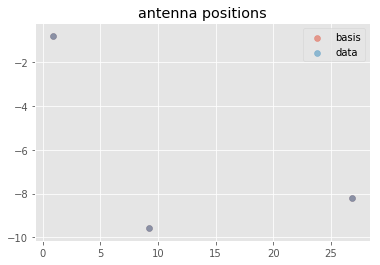

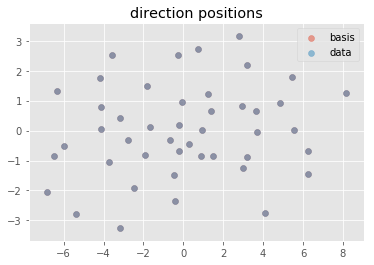

/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/tables-3.4.4-py3.6-linux-x86_64.egg/tables/file.py:767: DeprecationWarning: The use of uppercase keyword parameters is deprecated
  "deprecated", DeprecationWarning)
/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/gpflow-1.3.0-py3.6.egg/gpflow/_settings.py:67: DeprecationWarning: tf_int is deprecated and will be removed at GPflow version 1.2.0. Use int_type.
  'version 1.2.0. Use int_type.', DeprecationWarning)
/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/gpflow-1.3.0-py3.6.egg/gpflow/_settings.py:67: DeprecationWarning: tf_int is deprecated and will be removed at GPflow version 1.2.0. Use int_type.
  'version 1.2.0. Use int_type.', DeprecationWarning)
/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/gpflow-1.3.0-py3.6.egg/gpflow/_settings.py:67: DeprecationWarning: tf_int is deprecated and will be removed at GPflow version 1.2.0. Use int_type.
  'version 1.2.0. Use int_type.',

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 643.843202
  Number of iterations: 47
  Number of functions evaluations: 53


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 643.843202
  Number of iterations: 47
  Number of functions evaluations: 53


                                     class prior transform  trainable shape  \
GPR/kern/kernels/0/lengthscales  Parameter  None       +ve       True    ()   
GPR/kern/kernels/0/variance      Parameter  None       +ve      False    ()   
GPR/kern/kernels/1/lengthscales  Parameter  None       +ve       True    ()   
GPR/kern/kernels/1/variance      Parameter  None       +ve      False    ()   
GPR/kern/kernels/2/lengthscales  Parameter  None       +ve       True    ()   
GPR/kern/kernels/2/variance      Parameter  None       +ve      False    ()   
GPR/kern/kernels/3/offset        Parameter  None       +ve       True    ()   
GPR/kern/kernels/3/variance      Parameter  None       +ve       True    ()   
GPR/likelihood/variance          Parameter  None       +ve       True    ()   

                                 fixed_shape                 value  
GPR/kern/kernels/0/lengthscales         True    129.76160866396708  
GPR/kern/kernels/0/variance             True                   1.0  
GP

/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/hom

Instructions for updating:
Use tf.print instead of tf.Print. Note that tf.print returns a no-output operator that directly prints the output. Outside of defuns or eager mode, this operator will not be executed unless it is directly specified in session.run or used as a control dependency for other operators. This is only a concern in graph mode. Below is an example of how to ensure tf.print executes in graph mode:
```python
    sess = tf.Session()
    with sess.as_default():
        tensor = tf.range(10)
        print_op = tf.print(tensor)
        with tf.control_dependencies([print_op]):
          out = tf.add(tensor, tensor)
        sess.run(out)
    ```
Additionally, to use tf.print in python 2.7, users must make sure to import
the following:

  `from __future__ import print_function`



Instructions for updating:
Use tf.print instead of tf.Print. Note that tf.print returns a no-output operator that directly prints the output. Outside of defuns or eager mode, this operator will not be executed unless it is directly specified in session.run or used as a control dependency for other operators. This is only a concern in graph mode. Below is an example of how to ensure tf.print executes in graph mode:
```python
    sess = tf.Session()
    with sess.as_default():
        tensor = tf.range(10)
        print_op = tf.print(tensor)
        with tf.control_dependencies([print_op]):
          out = tf.add(tensor, tensor)
        sess.run(out)
    ```
Additionally, to use tf.print in python 2.7, users must make sure to import
the following:

  `from __future__ import print_function`

/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/gpflow-1.3.0-py3.6.egg/gpflow/_settings.py:67: DeprecationWarning: tf_int is deprecated and will be removed at GPflow version 1.2.0. Use 

In [3]:
import os

datapack = '../../scripts/data/DR2_full_smoothed.h5'
output_folder='./explore_rgp/DR2_precond_all_kern_check_all_ant'
os.makedirs(output_folder,exist_ok=True)

ant_sel = "RS50*"
time_sel = slice(1,100,1)
dir_sel = slice(0,None,1)
freq_sel = slice(12,13,1)
pol_sel = slice(0,1,1)

train_time=True
train_dir=True
train_ant=True
train_dot=True
dot_degree=1.

Nb = 10
lag = 0


with DataPack(datapack,readonly=False) as datapack:
    make_solsets(datapack,'posterior_sol_explore_15', screen_res=15, extend = 0.25, solset='sol000')
    datapack.select(ant=ant_sel,
                    freq=freq_sel,
                    time=time_sel,
                    dir=dir_sel, 
                    pol=pol_sel)
    datapack.switch_solset('sol000')
    phase, axes = datapack.phase
    _, Nd, Na, Nf, Nt = phase.shape
#     amp, axes = datapack.amplitude
    datapack.switch_solset('posterior_sol_explore_15')
    axes = datapack.axes_phase
    patch_names, directions = datapack.get_sources(axes['dir'])
    _, times = datapack.get_times(axes['time'])
    _, freqs = datapack.get_freqs(axes['freq'])
    antenna_labels, antennas = datapack.get_antennas(axes['ant'])
    
gains = np.exp(1j*phase)
dt=np.median(np.diff(times.mjd*86400.))


# 1, Na, Nf, 1
sigma_tec = np.sqrt(np.var(np.angle(gains[0,...]) * freqs[:,None]/-8.448e9, axis=-1, keepdims=True).mean(0,keepdims=True))
real_mean, imag_mean = gains_mean(freqs, sigma_tec, mean_amp=1.)

#Nd, Na, Nf, Nt
gi = gains.imag[0,...] - imag_mean
#Nd, Na, Nf, Nt
gr = gains.real[0,...] - real_mean

# #2, Nd, Na, Nf, Nt
# Y = np.concatenate([gains.real, gains.imag], axis = 0)
# Y_scale = 1.
# real_mean = 0.
# imag_mean = 0.

#2, Nd, Na, Nf, Nt
Y = np.concatenate([gr[None, ...], gi[None, ...]], axis = 0)
#2, 1, Na, Nf,1
Y_scale = np.sqrt(np.mean(Y*Y,axis=-1,keepdims=True).mean(1,keepdims=True))
#2, Nd, Na, Nf, Nt
Y /= Y_scale

Y_var = calculate_weights(Y,indep_axis=-1, N=3,phase_wrap=False,min_uncert=0.01)


antennas_enu = antennas.transform_to(ENU(obstime=times[0],location=datapack.array_center))
X_a = np.array([antennas_enu.east.value,
                antennas_enu.north.value]).T/1000.
X_d = np.array([directions.ra.deg - directions.ra.deg.mean(), directions.dec.deg - directions.dec.deg.mean()]).T
X_t = (times.mjd*86400 - times[0].mjd*86400.)[:,None]
X_f = freqs[:,None]/100e6 - freqs[0]/100e6

#2, Nf, Nt, Nd, Na
Y = Y.transpose((0,3,4,1,2))
_, Nf, Nt, Nd, Na = Y.shape
Y_var = Y_var.transpose((0,3,4,1,2))
Y = Y.reshape((2*Nf, Nt,Nd,Na))
Y_var = Y_var.reshape((2*Nf, Nt,Nd,Na))
D=2*Nf


###
# custom uncertainties
flag_dirs = [29]#[3,27,36,9,0,16,12,24,17,11,31,20,38,35,21,34,10,1]
select_dirs = np.where(~np.isin(np.arange(len(patch_names)), np.array(flag_dirs)))[0]
Y_var[:,:, flag_dirs,:] += 300.

###
# Define basis coords

Xb_d = X_d#basis_directions(X_d,f_min=0.5, f_max=0.75, fov=5.0, N=7, dialate=True)
Xb_a = basis_antennas(X_a,N=7)
Xb_f = np.linspace(X_f.min(), X_f.max(), 5)[:,None]

plt.scatter(Xb_a[:,0],Xb_a[:,1],label='basis',alpha=0.5)
plt.scatter(X_a[:,0],X_a[:,1],label='data',alpha=0.5)
plt.title('antenna positions')
plt.legend()
plt.show()

plt.scatter(Xb_d[:,0],Xb_d[:,1],label='basis',alpha=0.5)
plt.scatter(X_d[:,0],X_d[:,1],label='data',alpha=0.5)
plt.title('direction positions')
plt.legend()
plt.show()

###
# Get screen directions
with datapack:
    datapack.select(ant=ant_sel,
                    freq=freq_sel,
                    time=time_sel,
                    dir=slice(0,None,1), 
                    pol=pol_sel)
    _, X_screen_d, _, _ = get_solset_coords(datapack, 'screen_posterior_sol_explore_15')
# or build from scratch, but then can't plot without exra work
# X_screen_d = basis_directions(X_d,f_min=0.5, f_max=0.75, fov=5.0, N=7, dialate=True)

basis_coords_np = BasisStream(Xb_d, Xb_a)
data_coords_np = DataStream(X_t, X_d, X_a,  Y, Y_var)
screen_coords_np = ScreenStream(X_screen_d, X_a)

with tf.Session(graph=tf.Graph()) as sess:
    basis_coords = BasisStream(tf.placeholder(tf.float64,shape=Xb_d.shape), 
                               tf.placeholder(tf.float64,shape=Xb_a.shape),
#                                tf.placeholder(tf.float64,shape=Xb_f.shape)
                              )
    data_coords = DataStream(tf.placeholder(tf.float64,shape=X_t.shape), 
                             tf.placeholder(tf.float64,shape=X_d.shape), 
                             tf.placeholder(tf.float64,shape=X_a.shape), 
#                              tf.placeholder(tf.float64,shape=X_f.shape),
                             tf.placeholder(tf.float64,shape=Y.shape),
                             tf.placeholder(tf.float64,shape=Y_var.shape))
    screen_coords = ScreenStream(tf.placeholder(tf.float64,shape=X_screen_d.shape),
                                 tf.placeholder(tf.float64,shape=X_a.shape), 
#                                  tf.placeholder(tf.float64,shape=X_f.shape)
                                )
    ###
    # Define kernel 
    kern_time = gp.kernels.Matern52(1, active_dims = slice(0,1,1))
    kern_time.lengthscales = 111.
    kern_time.lengthscales.trainable = train_time
    kern_time.variance.trainable = False
    kern_dir = gp.kernels.RBF(2, active_dims = slice(1,3,1))
    kern_dir.lengthscales = 2.
    kern_dir.lengthscales.trainable = train_dir
    kern_dir.variance.trainable = False
    kern_ant = gp.kernels.Matern12(2, active_dims = slice(3,5,1),variance=1.)
    kern_ant.lengthscales = 28.
    kern_ant.lengthscales.trainable = train_ant
    kern_ant.variance.trainable = False
    # dependence on distance from center 
    kern_dot = gp.kernels.Polynomial(2, degree=dot_degree, variance=1, offset=0.1, active_dims = slice(1,3,1))
#     kern_freq = gp.kernels.RBF(1, active_dims = slice(5,6,1))
#     kern_freq.lengthscales = 2.
    if train_dot:
        kern = gp.multioutput.SharedIndependentMok(kern_time*kern_dir*kern_ant*kern_dot,D)
    else:
        kern = gp.multioutput.SharedIndependentMok(kern_time*kern_dir,D)

    mean = lambda X: tf.zeros([D, tf.shape(X)[0]], dtype=tf.float64)
    ###
    # fit params to subset of data
    X_fit = make_coord_array(X_t[:10:1],X_d[select_dirs,:],X_a[:,:])
    Y_fit = Y[:,:10:1,select_dirs,:].reshape((D,-1)).T
    Y_var_fit = Y_var[:,:10:1,select_dirs,:].reshape((D,-1)).T
    
#     m = GPRMultiOuput(X_fit,Y_fit,Y_var_fit,kern)
    m = gp.models.GPR(X_fit,Y_fit,kern.kern)
    m.likelihood.variance = Y_var_fit.mean()
    m.likelihood.variance.trainable=True
    gp.train.ScipyOptimizer().minimize(m)
    print(m)#2233, 2190, 2291, 2165, 2307

    (data_X, data_mu, data_C, 
     screen_X, screen_mu, screen_C,
     basis_X, basis_mu, basis_C,
    log_prob) = iteration_moving_activate_set_while_loop(data_coords, 
                                                        screen_coords, 
                                                        basis_coords, 
                                                        kern, mean, Nb=Nb, 
                                                        dt=dt, lag=lag)
    def _add_feed(d,pl,vl):
        for p,v in zip(pl,vl):
            d[p] = v
        return d
    
    feed_dict = _add_feed({},basis_coords, basis_coords_np)
    feed_dict = _add_feed(feed_dict,data_coords, data_coords_np)
    feed_dict = _add_feed(feed_dict,screen_coords, screen_coords_np)
    
    res = sess.run({'data_X':data_X, 
                    'data_mu':data_mu, 
                    'data_C':data_C, 
                     'screen_X':screen_X, 
                    'screen_mu':screen_mu, 
                    'screen_C':screen_C,
                     'basis_X':basis_X, 
                    'basis_mu':basis_mu, 
                    'basis_C':basis_C,
                    'log_prob':log_prob},feed_dict)
    

In [4]:
plt.figure(figsize=(12,12))
plt.plot(X_t[:,0], res['log_prob'])
plt.xlabel("time")
plt.ylabel("log P(y_t)")
plt.savefig(os.path.join(output_folder,'log_prob_evolution.png'))
plt.close("all")

_X = res['data_X'].reshape((Nt,Nd,Na,5))
_mu = res['data_mu'].transpose((1,0,2,3)).reshape((D,Nf,Nt,Nd,Na)).transpose((0,2,3,4,1))*Y_scale.transpose((0,4,1,2,3))
_C = res['data_C'].transpose((1,0,2)).reshape((D,Nf,Nt,Nd,Na)).transpose((0,2,3,4,1))*Y_scale.transpose((0,4,1,2,3))**2

gr_mu = _mu[0,...] + real_mean.transpose((3,0,1,2))
gr_std = np.sqrt(_C[0,...])
gi_mu = _mu[1,...]  + imag_mean.transpose((3,0,1,2))
gi_std = np.sqrt(_C[1,...])

#Npol, Nd, Na, Nf, Nt
phi = np.angle(gr_mu + 1j*gi_mu).transpose((1,2,3,0))[None,...]
var_phi = gr_std**2 * gi_mu**2 / (gi_mu**2 + gr_mu**2)**2 + gi_std**2 * gr_mu**2 / (gi_mu**2 + gr_mu**2)**2
var_phi = var_phi.transpose((1,2,3,0))[None,...]

with datapack:
    datapack.switch_solset('posterior_sol_explore_15')
    datapack.select(ant=ant_sel,
                    freq=freq_sel,
                    time=time_sel,
                    dir=dir_sel, 
                    pol=pol_sel)
    datapack.phase = phi
    datapack.weights_phase = 1./var_phi
    
_Nd = X_screen_d.shape[0]
    
_X = res['screen_X'].reshape((Nt,_Nd,Na,5))
_mu = res['screen_mu'].transpose((1,0,2)).reshape((D,Nf,Nt,_Nd,Na)).transpose((0,2,3,4,1))*Y_scale.transpose((0,4,1,2,3))
_C = res['screen_C'].transpose((1,0,2)).reshape((D,Nf,Nt,_Nd,Na)).transpose((0,2,3,4,1))*Y_scale.transpose((0,4,1,2,3))**2

gr_mu = _mu[0,...] + real_mean.transpose((3,0,1,2))
gr_std = np.sqrt(_C[0,...])
gi_mu = _mu[1,...]  + imag_mean.transpose((3,0,1,2))
gi_std = np.sqrt(_C[1,...])

#Npol, Nd, Na, Nf, Nt
phi = np.angle(gr_mu + 1j*gi_mu).transpose((1,2,3,0))[None,...]
#phi = arctan(imag/real)
#sigma_phi^2 = sigma_real^2 imag^2/(imag^2 + real^2)^2 + sigma_imag^2 real^2/(imag^2 + real^2)^2
var_phi = gr_std**2 * gi_mu**2 / (gi_mu**2 + gr_mu**2)**2 + gi_std**2 * gr_mu**2 / (gi_mu**2 + gr_mu**2)**2
var_phi = var_phi.transpose((1,2,3,0))[None,...]

with datapack:
    datapack.switch_solset('screen_posterior_sol_explore_15')
    datapack.select(ant=ant_sel,
                    freq=freq_sel,
                    time=time_sel,
                    dir=slice(0,None,1), 
                    pol=pol_sel)
    datapack.phase = phi
    datapack.weights_phase = 1./var_phi
    


from bayes_tec.plotting.plot_datapack import animate_datapack

animate_datapack(datapack.filename,os.path.join(output_folder,'2d_screen'),
                 10, labels_in_radec=True, solset='screen_posterior_sol_explore_15', observable='phase', 
                 plot_screen=True, ant_sel=ant_sel,freq_sel=freq_sel,
                 pol_sel=pol_sel,time_sel=time_sel,dir_sel=None)

animate_datapack(datapack.filename,os.path.join(output_folder,'2d_facets'),
                 10, labels_in_radec=True, plot_facet_idx=True, 
                 solset='posterior_sol_explore_15', observable='phase', 
                 plot_screen=False, ant_sel=ant_sel,freq_sel=freq_sel,
                 pol_sel=pol_sel,time_sel=time_sel,dir_sel=dir_sel)

animate_datapack(datapack.filename,os.path.join(output_folder,'2d_screen_std'),
                 10, labels_in_radec=True, solset='screen_posterior_sol_explore_15', observable='weights_phase', 
                 plot_screen=True, ant_sel=ant_sel,freq_sel=freq_sel,
                 pol_sel=pol_sel,time_sel=time_sel,dir_sel=None,vmin=0,vmax=1.)

animate_datapack(datapack.filename,os.path.join(output_folder,'2d_facets_std'),
                 10, labels_in_radec=True, plot_facet_idx=True, 
                 solset='posterior_sol_explore_15', observable='weights_phase', 
                 plot_screen=False, ant_sel=ant_sel,freq_sel=freq_sel,
                 pol_sel=pol_sel,time_sel=time_sel,dir_sel=dir_sel,vmin=0,vmax=1.)


/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/tables-3.4.4-py3.6-linux-x86_64.egg/tables/file.py:767: DeprecationWarning: The use of uppercase keyword parameters is deprecated
  "deprecated", DeprecationWarning)
/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/tables-3.4.4-py3.6-linux-x86_64.egg/tables/file.py:767: DeprecationWarning: The use of uppercase keyword parameters is deprecated
  "deprecated", DeprecationWarning)
/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/tables-3.4.4-py3.6-linux-x86_64.egg/tables/file.py:767: DeprecationWarning: The use of uppercase keyword parameters is deprecated
  "deprecated", DeprecationWarning)
/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/tables-3.4.4-py3.6-linux-x86_64.egg/tables/file.py:767: DeprecationWarning: The use of uppercase keyword parameters is deprecated
  "deprecated", DeprecationWarning)
/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/tables-3.4.4-py3.6-li

/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/tables-3.4.4-py3.6-linux-x86_64.egg/tables/file.py:767: DeprecationWarning: The use of uppercase keyword parameters is deprecated
  "deprecated", DeprecationWarning)
/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/tables-3.4.4-py3.6-linux-x86_64.egg/tables/file.py:767: DeprecationWarning: The use of uppercase keyword parameters is deprecated
  "deprecated", DeprecationWarning)
/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/tables-3.4.4-py3.6-linux-x86_64.egg/tables/file.py:767: DeprecationWarning: The use of uppercase keyword parameters is deprecated
  "deprecated", DeprecationWarning)
/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/tables-3.4.4-py3.6-linux-x86_64.egg/tables/file.py:767: DeprecationWarning: The use of uppercase keyword parameters is deprecated
  "deprecated", DeprecationWarning)
/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/tables-3.4.4-py3.6-li

/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/tables-3.4.4-py3.6-linux-x86_64.egg/tables/file.py:767: DeprecationWarning: The use of uppercase keyword parameters is deprecated
  "deprecated", DeprecationWarning)
/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/tables-3.4.4-py3.6-linux-x86_64.egg/tables/file.py:767: DeprecationWarning: The use of uppercase keyword parameters is deprecated
  "deprecated", DeprecationWarning)
/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/tables-3.4.4-py3.6-linux-x86_64.egg/tables/file.py:767: DeprecationWarning: The use of uppercase keyword parameters is deprecated
  "deprecated", DeprecationWarning)
/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/tables-3.4.4-py3.6-linux-x86_64.egg/tables/file.py:767: DeprecationWarning: The use of uppercase keyword parameters is deprecated
  "deprecated", DeprecationWarning)
/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/tables-3.4.4-py3.6-li

In [5]:
res['data_mu'].reshape((99,2,45,3,1))[...,2,0] - res['data_mu'].reshape((99,2,45,3,1))[...,1,0]

array([[[-2.72528000e-01, -8.09819624e-01,  2.64659801e+00, ...,
          6.95327819e-01,  2.79328385e-01, -1.11574664e+00],
        [-1.43534782e+00, -3.30523373e-01, -2.61222664e-01, ...,
         -7.42238229e-04,  9.02768038e-04, -1.45218331e+00]],

       [[-2.23410875e-01, -2.67049378e-01,  2.94786226e+00, ...,
          1.68325347e+00,  4.64404010e-01, -8.84791099e-01],
        [-1.39217517e+00,  6.82223206e-03, -2.77858155e-01, ...,
         -1.78434134e-01, -2.88748746e-01, -1.11646388e+00]],

       [[ 2.21557611e-01, -5.34432540e-02,  2.77343509e+00, ...,
          2.07994648e+00,  7.84926693e-01, -2.36507012e-01],
        [-3.77960482e-01,  2.72157989e-02, -2.62214865e-01, ...,
         -1.11829000e-01, -3.92877121e-01, -3.80131764e-01]],

       ...,

       [[-2.42326713e-01, -1.38738193e+00, -3.58495295e-01, ...,
          2.50483463e-01,  1.22142127e-01, -5.20593032e-01],
        [-4.55868158e-01, -1.49689975e+00, -1.19479924e+00, ...,
          7.54194745e-01,  4.78486

In [6]:
_Na = Xb_a.shape[0]
_Nd = Xb_d.shape[0]
Nb = 10
_X = res['basis_X'].reshape((Nt,Nb,_Nd,_Na,5))


#2,1, 1 ,1, Na,Nf
#D,Nt,Nd,Na,Nf,Nb
_mu = res['basis_mu']
_mu = _mu.transpose((1,0,2)).reshape((D,Nf,Nt,Nb,_Nd,_Na))
#D,Nt,Nb,Nd,Na,Nf
_mu = _mu.transpose((0,2,3,4,5,1))*Y_scale[:,:,None,None,:,:,0].mean(4,keepdims=True)
_mu = _mu.transpose((0,1,3,4,5,2))
_C = res['basis_C']
_C = _C.transpose((1,0,2)).reshape((D,Nf,Nt,Nb,_Nd,_Na))
_C = _C.transpose((0,2,3,4,5,1))*Y_scale[:,:,None, None, :,:,0].mean(4,keepdims=True)**2
_C = _C.transpose((0,1,3,4,5,2))
#Nb, Nd, Na, Nf, Nt
gr_mu = _mu[0,...] + real_mean[None,...].mean(2,keepdims=True)
gr_std = np.sqrt(_C[0,...])
gi_mu = _mu[1,...]  + imag_mean[None,...].mean(2,keepdims=True)
gi_std = np.sqrt(_C[1,...])

phi = np.angle(gr_mu + 1j*gi_mu)
std_phi = np.sqrt(gr_std**2 * gi_mu**2 / (gi_mu**2 + gr_mu**2)**2 + gi_std**2 * gr_mu**2 / (gi_mu**2 + gr_mu**2)**2)

##
# data

data_X = res['data_X'].reshape((Nt,Nd,Na,5))
_mu = res['data_mu'].transpose((1,0,2,3)).reshape((D,Nf,Nt,Nd,Na)).transpose((0,2,3,4,1))*Y_scale.transpose((0,4,1,2,3))
_C = res['data_C'].transpose((1,0,2)).reshape((D,Nf,Nt,Nd,Na)).transpose((0,2,3,4,1))*Y_scale.transpose((0,4,1,2,3))**2

gr_mu = _mu[0,...] + real_mean.transpose((3,0,1,2))
gr_std = np.sqrt(_C[0,...])
gi_mu = _mu[1,...]  + imag_mean.transpose((3,0,1,2))
gi_std = np.sqrt(_C[1,...])

#Nt, Nd, Na, Nf
data_phi = np.angle(gr_mu + 1j*gi_mu)
data_std_phi = np.sqrt(gr_std**2 * gi_mu**2 / (gi_mu**2 + gr_mu**2)**2 + gi_std**2 * gr_mu**2 / (gi_mu**2 + gr_mu**2)**2)

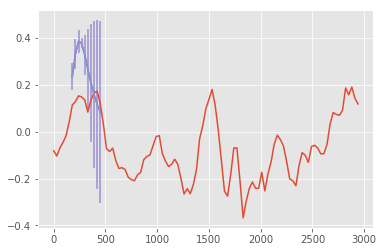

In [7]:
%matplotlib inline
gi_mu.shape
i=9
plt.plot(data_X[:,39,0,0],data_phi[:,39,0,0])
plt.plot(_X[i,:,39,0,0],phi[i,39,0,0,:])
plt.errorbar(_X[i,:,39,0,0],phi[i,39,0,0,:],yerr=std_phi[i,39,0,0,:])
plt.show()

/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/tables-3.4.4-py3.6-linux-x86_64.egg/tables/file.py:767: DeprecationWarning: The use of uppercase keyword parameters is deprecated
  "deprecated", DeprecationWarning)


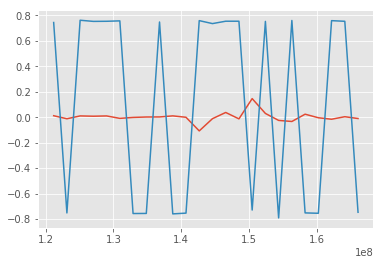

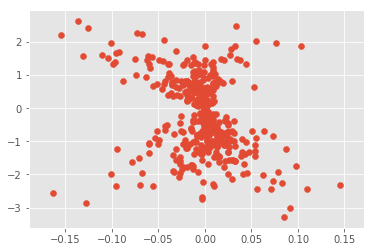

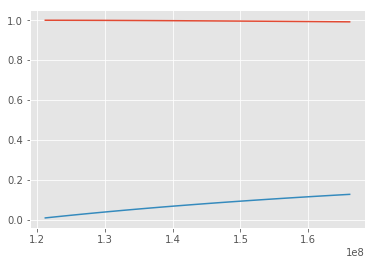

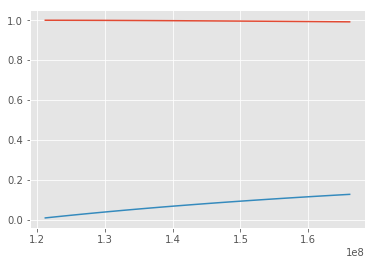

-0.0038856594945341602 -0.20206110843226707
(5.706310746145249e-08-2.4253227759452045e-09j)


In [8]:
with DataPack('../../scripts/data/DR2_full_smoothed.h5',readonly=True) as datapack:

    datapack.select(ant='RS50*',
                    freq=None,
                    time=None,
                    dir=None, 
                    pol=slice(0,1,1))
    datapack.switch_solset('sol000')
    phase, axes = datapack.phase
    _, Nd, Na, Nf, Nt = phase.shape
#     amp, axes = datapack.amplitude
    patch_names, directions = datapack.get_sources(axes['dir'])
    _, times = datapack.get_times(axes['time'])
    _, freqs = datapack.get_freqs(axes['freq'])
    antenna_labels, antennas = datapack.get_antennas(axes['ant'])

class GainTransform(object):
    def __init__(self,freqs, sigma_tec, mean_amp=1.):
        """
        freqs: array (Nf,)
        sigma_tec: array (..., Nf, 1)
        """
        self.Nf = len(freqs)
        #(..., Nf, 1)
        self.real_mean, self.imag_mean = gains_mean(freqs, sigma_tec, mean_amp=1.)
        #(..., Nf, Nf)
        cov_real, cov_imag = self.freq_cov(freqs,sigma_tec,mean_amp=1.)
        
        self.shape = cov_real.shape
        u,s,vh = np.linalg.svd(cov_real.reshape((-1,self.Nf,self.Nf)))
        self.L_real = np.einsum('bnm,bm,bml->bnl',u,np.sqrt(s), vh)


        u,s,vh = np.linalg.svd(cov_imag.reshape((-1,self.Nf,self.Nf)))
        self.L_imag = np.einsum('bnm,bm,bml->bnl',u,np.sqrt(s), vh)
        self._amp = None
    
    def whiten(self, gains):
        """
        gains: array (..., Nf, Nt)
        returns:
        array: array (..., Nf, Nt)
        """
        Nf,Nt = gains.shape[-2:]
        assert Nf == self.Nf
        gr = gains.real - self.real_mean
        gr = np.linalg.solve(self.L_real,gr.reshape((-1,Nf,Nt))).reshape(gr.shape)
        
        gi = gains.imag - self.imag_mean
        gi = np.linalg.solve(self.L_imag,gi.reshape((-1,Nf,Nt))).reshape(gi.shape)
        
        gains = gr + 1j*gi
        
        self._amp = np.maximum(np.std(gains,axis=-1,keepdims=True), 0.01)
        return gains/self._amp
    
    def unwhiten(self,gains):
        """
        gains: array (..., Nf, Nt)
        returns:
        array: array (..., Nf, Nt)
        """
        Nf,Nt = gains.shape[-2:]
        assert Nf == self.Nf
        assert self._amp is not None
        gains = gains*self._amp
        gr = gains.real
        gr = np.einsum("bnm,bml->bnl",self.L_real, gr.reshape((-1,Nf,Nt))).reshape(gr.shape)
        gr = gr + self.real_mean
        
        gi = gains.imag
        gi = np.einsum("bnm,bml->bnl",self.L_imag, gi.reshape((-1,Nf,Nt))).reshape(gi.shape)
        gi = gi + self.imag_mean
        
        return gr + 1j*gi
    
    def unwhiten_variance(self,gains_var):
        """
        gains_var: array (..., Nf, Nt)
        returns:
        array: array (..., Nf, Nt)
        """
        Nf,Nt = gains_var.shape[-2:]
        shape = gains_var.shape[:-2]
        assert Nf == self.Nf
        assert self._amp is not None
        gains_var = gains_var*self._amp**2
        gr = gains_var.real
        #L.Sigma.L^T
        gr = np.einsum("bnm,bml,bkm->bnkl",self.L_real, gr.reshape((-1,Nf,Nt)), self.L_real).reshape(shape+(Nf,Nf,Nt))
        
        gi = gains_var.imag
        #L.Sigma.L^T
        gi = np.einsum("bnm,bml,bkm->bnkl",self.L_imag, gi.reshape((-1,Nf,Nt)), self.L_imag).reshape(shape+(Nf,Nf,Nt))
        
        return gr + 1j*gi
        
        
    def gains_mean(self, freq, sigma_tec, mean_amp=1.):
        """Returns mean of real and imaginary pary"""
        mean_real = mean_amp * np.exp(-0.5*(8.448e9*sigma_tec/freq[:,None])**2 )
        mean_imag = np.zeros_like(mean_real)
        return mean_real, mean_imag
        
        
    def freq_cov(self,freqs,sigma_tec,mean_amp=1.):
        """
        freqs: array (Nf,)
        sigma_tec: array (..., Nf, 1)
        returns:
        array (..., Nf, Nf)
        """
        tec_conv = -8.448e9/freqs
        #..., Nf, 1
        real_mean,real_imag = gains_mean(freqs,sigma_tec,mean_amp=1.)
        #..., Nf,Nf
        A = real_mean*np.swapaxes(real_mean,-1,-2)
        #...,Nf,Nf
        B = tec_conv[:,None]*sigma_tec
        B = B*np.swapaxes(B,-1,-2)
        #...,Nf,Nf
        cov_real = A*(np.cosh(B) - 1.)
        cov_imag = A*np.sinh(B)
        return cov_real, cov_imag
    
    


gains = np.exp(1j*phase)

# Npol, Nd, Na, Nf, 1
sigma_tec = np.sqrt(np.var(np.angle(gains) * freqs[:,None]/-8.448e9, axis=-1, keepdims=True))
G = GainTransform(freqs, sigma_tec)
gt = G.whiten(gains)

gut = G.unwhiten(gt)

gut_var = G.unwhiten_variance(np.ones_like(gt)*0.01**2)

plt.plot(freqs,gt.real[0,0,0,:,50])
plt.plot(freqs,gt.imag[0,0,0,:,50])
plt.show()

plt.scatter(gt.real[0,0,0,0,:500],gt.imag[0,0,0,0,:500])
plt.show()
plt.plot(freqs,gains.real[0,0,0,:,50])
plt.plot(freqs,gains.imag[0,0,0,:,50])
plt.show()
plt.plot(freqs,gut.real[0,0,0,:,50])
plt.plot(freqs,gut.imag[0,0,0,:,50])
plt.show()


print(np.mean(gt.real[0,0,0,0,:500]),np.mean(gt.imag[0,0,0,0,:500]))

print(np.max(gut - gains))




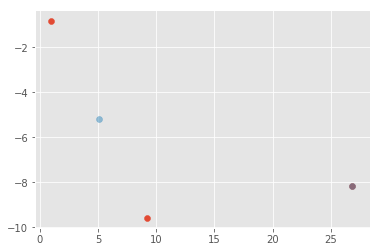

In [9]:
C_a = basis_antennas(X_a, N=2)


plt.scatter(X_a[:,0],X_a[:,1])
plt.scatter(C_a[:,0],C_a[:,1],alpha=0.5)
plt.show()

In [10]:
with datapack:
    datapack.select(ant=None)
    print(datapack.antennas)

(array([b'CS001HBA0', b'CS001HBA1', b'CS002HBA0', b'CS002HBA1',
       b'CS003HBA0', b'CS003HBA1', b'CS004HBA0', b'CS004HBA1',
       b'CS005HBA0', b'CS005HBA1', b'CS006HBA0', b'CS006HBA1',
       b'CS007HBA0', b'CS007HBA1', b'CS011HBA0', b'CS011HBA1',
       b'CS013HBA0', b'CS013HBA1', b'CS017HBA0', b'CS017HBA1',
       b'CS021HBA0', b'CS021HBA1', b'CS024HBA0', b'CS024HBA1',
       b'CS026HBA0', b'CS026HBA1', b'CS028HBA0', b'CS028HBA1',
       b'CS030HBA0', b'CS030HBA1', b'CS031HBA0', b'CS031HBA1',
       b'CS032HBA0', b'CS032HBA1', b'CS101HBA0', b'CS101HBA1',
       b'CS103HBA0', b'CS103HBA1', b'CS201HBA0', b'CS201HBA1',
       b'CS301HBA0', b'CS301HBA1', b'CS302HBA0', b'CS302HBA1',
       b'CS401HBA0', b'CS401HBA1', b'CS501HBA0', b'CS501HBA1',
       b'RS106HBA', b'RS205HBA', b'RS208HBA', b'RS210HBA', b'RS305HBA',
       b'RS306HBA', b'RS307HBA', b'RS310HBA', b'RS406HBA', b'RS407HBA',
       b'RS409HBA', b'RS503HBA', b'RS508HBA', b'RS509HBA'], dtype='|S9'), array([[0., 0., 0.],
    

/home/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/tables-3.4.4-py3.6-linux-x86_64.egg/tables/file.py:767: DeprecationWarning: The use of uppercase keyword parameters is deprecated
  "deprecated", DeprecationWarning)
